#  **What do UMD Students Look for in a Good Professor?**
### *A Study and Visualization in Data Science and Machine Learning*
---


Spring 2025 Data Science Final Project  
Matthew Nguyen, Jay Ren, Richard Gancayco

Contributions:

- **Richard Gancayco** was in charge of: (A) project idea, (B) data set curation and preprocesssing, (C) data exploration and summary statisitcs, and he also advised some on a high level for the machine learning design. The corresponding report sections for (B) and (C) that further document and detail his work were also written mostly by Richard.

- **Matthew Nguyen** worked on Method 3 of (C) data exploration and summary statisitcs, (D) ML Algorithm Design/Development, (E) ML Algorithm Training and Test Data Analysis, (F) Visualization, Result Analysis, Conclusion, (G) Final Tutorial Report Creation. Worked with Jay to generate different models (Decision Tree, KNN, Logistic Regression), comparing their results, and choosing the most efficient ML model (Tuned Decision Tree). Visualized the Tuned Decision Tree. Created the initial format for the Final Tutorial Report. Additionally, collaborated with group members on parts of each section.

- **Jay Ren** was in charge of: Collaboration on (D) ML Algorithm Design/Development, (E) ML Algorithm Training and Test Data Anlysis, and (F) Visualization. Contributed to the idea of using different models to compare their results in order to determine the most efficient ML model.




---


## **Introduction**
We UMD students often rely on online professor ratings and reviews to help plan the best learning experience for our upcoming semesters. Using techniques in data science and machine learning, we attempt to predict whether or not a new professor will be "preferable"-- specifically measured as having a rating of 4 out of 5 stars or higher on the site PlaneTerp.com-- based on current professors' gathered data of student GPA, department, salary, education level, and more.

Moreover, we can observe which of these factors are most influential in determining student rating and preferability. For example, whom will students typically rate better: a professor with a Ph.D, $200k salary, and years of experience teaching; or a professor with none of those but simply awards higher grades to their students? We hope to shed light on such questions and more through our work.

Please note that the coding done for data curation was done loosely in a separate file, but enough to explain the general process will be presented below. Note also that data curation for name, rating, and students' GPA was already done in Checkpoint 2, and only curation of the new additional features will be shown.



---


## **Data Curation**
Our dataset is a table of 2,042 UMD undergraduate professors and their various features. Our dataset was not some convenient csv file that was already pre-compiled and ready to experiment upon– its contents were instead carefully gathered, scraped, extrapolated, and combined from several APIs and websites.

First, using Python’s Request library and the PlanetTerp.com API , we found the professor features of:

- Average rating (1-5 stars)

- Total number of ratings

- The average GPA of the students who take the professor

- The number of classes taught (not to be confused with the number of unique courses taught).

The next source was  the UMD Academic Catalog for undergraduate faculty. This is simply a web page listing all the undergraduate faculty, and we wrote code in JavaScript to parse the page’s HTML code and find certain features for each listed person, namely:

- UMD school/department (e.g. CMNS)

- Position (e.g. Lecturer, Professor Emeritus)

- The highest level of education (Bachelor’s degree, Master’s degree, Ph.D)

- Approximate Age

- Approximate Gender

  Age was approximated by assuming the professor was 22 years old at the provided date they received their undergraduate degree (e.g. a professor who earned their Bachelor's degree in 1990 is estimated to be 2025-(1990-22) = 57 years old).

  Gender was approximated by the API of Genderize.io, a trusted site that uses a wide database and machine learning algorithms to predict a gender given a name.

Lastly, the 2024 salaries of each professor was found on the openthebooks.com, a site dedicated to making-transparent the details of government workers (UMD and its staff are funded by the state government) for the sake of accountability to the public. Like the UMD academic catalog, this site had no csv file or API, and we had to code a basic web scraper in Javascript to lookup and extract the 2024 salary of as many UMD professors as possible. We could not find salaries for approximately 12% of the 2,042 professors we queried, so we filled these missing values with the median salary of $136,000 (since salaries tend to have upwards outliers).

In our later machine learning practices, the nine gathered features for professors– number of ratings, students’ GPA, number of classes taught, department, position, education, age, gender, and salary– were the independent x variables; and the dependent variable, a binary classification, was whether or not the professor was “preferable”, i.e. had an average PlanetTerp rating of 4 or higher out of 5 stars.

### Links for data sources and tools:

- PlanetTerp: https://planetterp.com/api/

- UMD Academic Catalog: https://academiccatalog.umd.edu/undergraduate/administrators-officials-faculty/

- Genderize: https://genderize.io/

- OpenTheBooks: https://www.openthebooks.com/maryland-state-employees/?Year_S=2024&Emp_S=University%20of%20Maryland


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#for display purposes only, not meant to be run again since it
# may refer to obsolete and unmentioned variables from a practice file...
#-----------------------------------------------------------------------------------------
#code to get number of reviews and number of classes taught
import requests

rows = []
for name in info_and_ratings['Name']:
    res = requests.get(f"https://api.planetterp.com/v1/professor?name={name}&reviews=true").json()
    if not "error" in res.keys():
        num_reviews = len(res.get("reviews"))
        num_classes_taught = len(res.get("courses"))
        #append new info to array
        rows.append({'Name':name,'num_reviews':num_reviews,'num_classes_taught':num_classes_taught})

#create dataframe from array
num_reviews_and_classes = pd.DataFrame(rows)
#merge it with the main dataframe
info_ratings_revs_classes = pd.merge(info_and_ratings, num_reviews_and_classes, on='Name', how='outer')

#-----------------------------------------------------------------------------------------
#guess gender based on name
# I had to pay $20 to do the ~2,000 API requests by the way...
rows = []
for name in info_ratings_revs_classes['Name']:
    api_key = "831a9cdf5bdac7a54b9c1edc96fa04dd"
    res = requests.get(f"https://api.genderize.io?name={name}&apikey={api_key}").json()
    if not "error" in res.keys():
        gender = res.get("gender")
        rows.append({'Name':name,'Most Likely Gender':gender})
#create dataframe from array
prof_genders = pd.DataFrame(rows)
#merge it with the main dataframe
merged_with_genders= pd.merge(info_ratings_revs_classes, prof_genders, on='Name', how='outer')
merged_with_genders = merged_with_genders.drop_duplicates()

#-----------------------------------------------------------------------------------------
#!!! the code to find education, position, age, and department was all done in Javascript, parsing a big HTML file
#here is a small sample:
"""
  function parseHtml() {
    const nodeList = document.querySelectorAll('.faculty-item');   // Select all the names

    let csvContent = "Name,Position,Department,Highest Education,Approximate Age\n";  // Add column header

    //the helper functions are omitted but they are just string parsers and regular expressions to find certain terms basically
    nodeList.forEach(function(personObject) {
      person = personObject.outerHTML
      let name = extractStrongContent(person).split(',').reverse().join(',').replace(/,/g, '');
      let position = extractBetweenBrAndComma(person).replace(/&amp;/g, 'and');
      let department = findFirstFourCaps(person)
      let highestEd = getDegreeType(person)
      let approximateAge = calculateAdjustedYear(person)
      csvContent += `${name},${position},${department},${highestEd},${approximateAge}\n`
    });
    //code to convert from string to csv is omitted

"""

#-----------------------------------------------------------------------------------------
#helper function to find 2024 salary of each professor
def extract_price_substring(s):
    #the salary is always in these HTML "tags"
    start_token = "<td>$"
    end_token = ".00</td>"

    start_index = s.find(start_token)
    end_index = s.find(end_token, start_index)

    if start_index == -1 or end_index == -1:
        return None  # Pattern not found

    start_index += len(start_token)
    return s[start_index:end_index]

#helper function to get the web page associated with a name, convert it into bytes, then a string, then parse that string to find the salary
def find_salary(first_name, last_name):
    url = f"https://www.openthebooks.com/maryland-state-employees/?F_Name_S={last_name}%20{first_name}&Year_S=2024&Emp_S=University%20of%20Maryland"

    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})

    fp = urllib.request.urlopen(req)

    mybytes = fp.read()
    mystr = mybytes.decode("utf8")
    fp.close()
    salary_str = extract_price_substring(mystr)
    if salary_str is None:
        return None
    else:
        return int(salary_str.replace(",", ""))

#main code that calls the above two functions, probably inefficient and took 3 hours to run :(
# given a name, get their 2024 salary
import time
rows = []
count = 0
for name in merged_with_genders['Name']:
    count += 1
    name_arr = name.split(" ")
    first_name = name_arr[0]
    last_name = name_arr[1]
    salary = find_salary(first_name, last_name)
    print(f"count: {count}, name: {name}, salary: ${salary}")
    rows.append({'Name':name,'2024 salary':salary})

    # saving my work every 50 entries because there was often some server error coming up
    if count%50 == 0:
        temp_df = pd.DataFrame(rows)
        temp_df.to_csv("salaries.csv",index=False)

    #I had to add this sleep line because I was overloading the server or something and it was kicking me out for too many requests per hour
    time.sleep(4)

merged_with_salary = pd.DataFrame(rows)
merged_with_salary.to_csv("salaries_all.csv",index=False)

#example header of final dataframe, sorted by highest salaries:
merged_with_salaries.sort_values(by='salary_2024',ascending=False).reset_index().head(10)



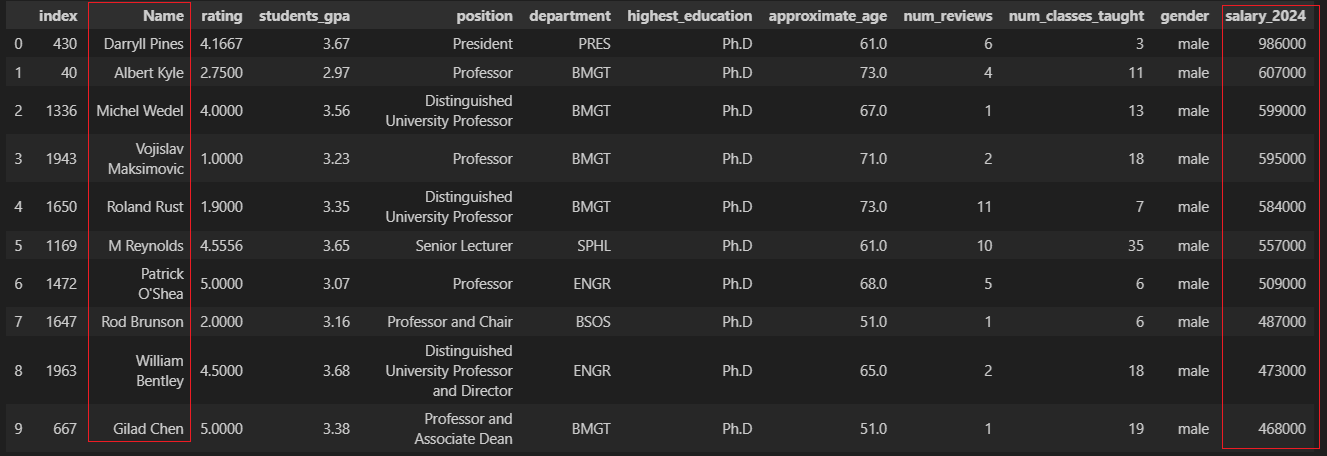

Here are some basic summary statistics of each feature.

In [ ]:
df = pd.read_csv('professor_data_final.csv')
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          2042 non-null   int64  
 1   Name                2042 non-null   object 
 2   rating              2042 non-null   float64
 3   students_gpa        2042 non-null   float64
 4   position            2042 non-null   object 
 5   department          2042 non-null   object 
 6   highest_education   2042 non-null   object 
 7   approximate_age     2042 non-null   float64
 8   num_reviews         2042 non-null   int64  
 9   num_classes_taught  2042 non-null   int64  
 10  gender              2042 non-null   object 
 11  salary_2024         2042 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 191.6+ KB


,Unnamed: 0,Name,rating,students_gpa,position,department,highest_education,approximate_age,num_reviews,num_classes_taught,gender,salary_2024
count,2042.000000,2042,2042.000000,2042.000000,2042,2042,2042,2042.000000,2042.000000,2042.000000,2042,2042.000000
unique,NaN,2031,NaN,NaN,60,19,3,NaN,NaN,NaN,2,NaN
top,NaN,Douglas Hamilton,NaN,NaN,Lecturer,ARHU,Ph.D,NaN,NaN,NaN,male,NaN
freq,NaN,4,NaN,NaN,461,468,1558,NaN,NaN,NaN,1263,NaN
mean,1020.500000,NaN,3.844482,3.202356,NaN,NaN,NaN,54.151322,13.150343,17.278159,NaN,145206.660137
std,589.618945,NaN,1.050681,0.459215,NaN,NaN,NaN,14.383190,24.325218,11.200371,NaN,92706.727795
min,0.000000,NaN,1.000000,0.000000,NaN,NaN,NaN,25.000000,1.000000,1.000000,NaN,1000.000000
25%,510.250000,NaN,3.105300,2.980000,NaN,NaN,NaN,42.000000,3.000000,9.000000,NaN,87000.000000
50%,1020.500000,NaN,4.000000,3.290000,NaN,NaN,NaN,53.000000,6.000000,15.000000,NaN,136000.000000
75%,1530.750000,NaN,4.800000,3.520000,NaN,NaN,NaN,65.000000,14.000000,23.000000,NaN,189000.000000


---
## **Exploratory Data Analysis**

Our Checkpoint #2's dataset only had professor's features for average rating, number of reviews, and students' GPA. As observed in the previous section, we have since gathered much more valuable information like salary and age. We would be remiss to not study and visualize these valuable new findings before our machine learning analysis.

It is also worth mentioning that our Checkpoint #2's visualizations placed student's GPA as the dependent variable affected and predicted by the independent variable of rating. But in reconsideration, we believe it logical to instead have the rating as the dependent and predicted variable, with students' GPA and the other new features as the independent variables.
Therefore our next visualizations will plot the rating by each individual variable, and find the correlation coeffcient, linear regression line, R-squared value.

 Note that linear regression is a basic form of machine learning, and the resulting plots foreshadow our later findings in the deeper machine learning section. First displayed are the continuous variables of students' GPA, 2024 salary, approximate age, number of reviews, number of classes taught, and their relationship to rating.

 Outliers (defined as having value more than 3 standard deviatiosn from the mean) for the features of salary and number of reviews are considered when formulating the regression line and correlation, but they are deliberately cut off from the graphs because their inclusion truncate the x axis too much and skew the regression line's display misleadingly.

### Individual Plots of Professor Rating by Each x Variable:
### For Continuous Data:
(rating by students' GPA, 2024 salary, approximate age, number of reviews, number of classes taught)

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as colors
from sklearn.metrics import r2_score

# plot as a scatterplot the relationship of individual variables and the professor's rating
independent_variables = ['students_gpa','num_reviews','salary_2024','approximate_age','num_classes_taught']

def chart_relationship_with_rating(independent_variable, dependent_variable):

    x_vals = merged_with_salaries[independent_variable]
    y_vals = merged_with_salaries[dependent_variable]

    #find correlation coefficient
    coerr, p = stats.pearsonr(x_vals,y_vals)

    plt.scatter(x_vals, y_vals,s=5,c=y_vals.apply(lambda x: x), cmap='viridis',norm=colors.Normalize(vmin=1, vmax=4))

    #find regression line
    slope, intercept = np.polyfit(x_vals, y_vals, 1)
    regression_line = slope * x_vals + intercept
    r_squared = r_squared = r2_score(y_vals, regression_line)
    plt.plot(x_vals, regression_line, linewidth=.5, color='red', label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')

    plt.suptitle('Professor\'s Rating by '+independent_variable, fontsize=12, fontweight="bold", y=1.05)
    plt.title('Number of points/professors: '+str(len(merged_with_salaries))+'\
            \nCorrelation: '+str(round(coerr,3))+\
            f'\nRegression Line: y = {slope:.6f}x + {intercept:.2f}'\
            f'\nR squared:  = {r_squared:.4f}', fontsize=9)
    plt.ylabel('Professor\'s Average PlanetTerp Rating', fontsize=10)
    plt.xlabel(independent_variable, fontsize= 10)

    # plot, but do not display, upwards outliers (more than 3 std devs from mean),
    #    because these truncate the x axis too much and skew the regression line's display misleadingly
    if independent_variable == 'salary_2024':
        plt.xlim(0,420000)
    if independent_variable == 'num_reviews':
        plt.xlim(0,85)

    plt.ylim(.9, 5.1)
    plt.grid(True, alpha = 0.4)

    plt.show()
    print(f"summary statisitcs of {independent_variable}")
    #print(merged_with_salaries[independent_variable].describe().map('{:.2f}'.format))

for independent_variable in independent_variables:
    chart_relationship_with_rating(independent_variable, 'rating')

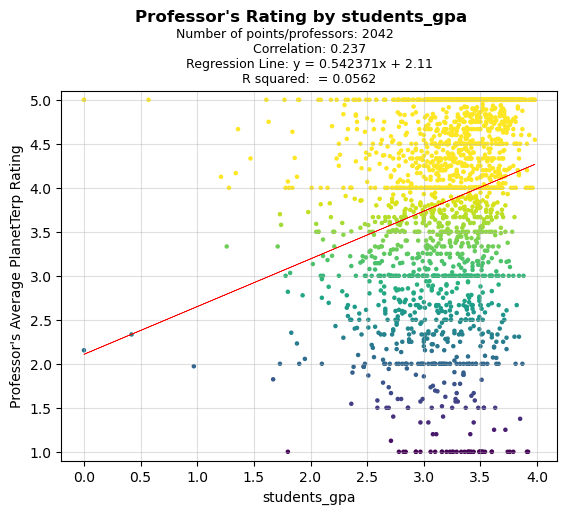
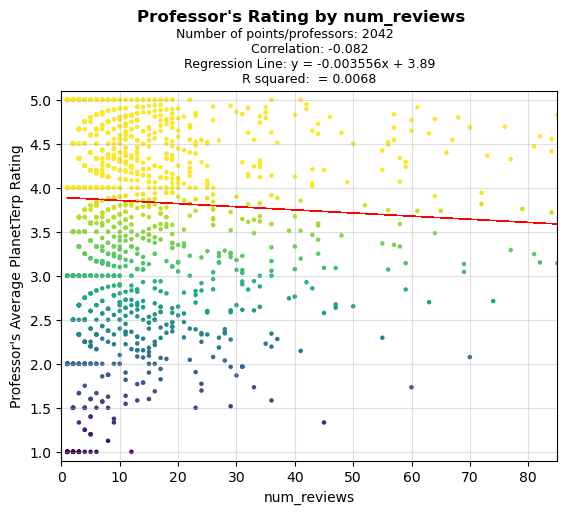

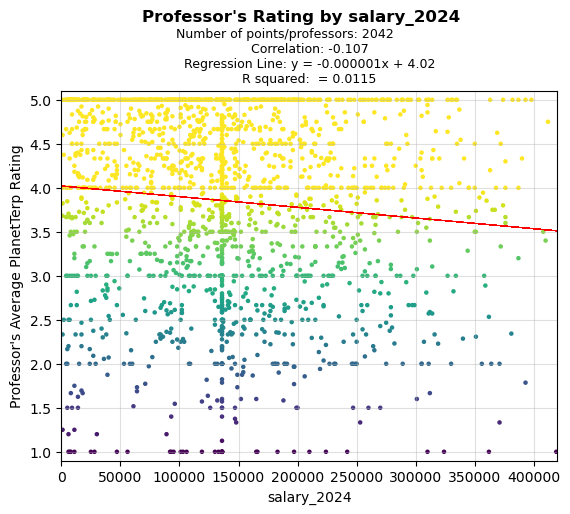
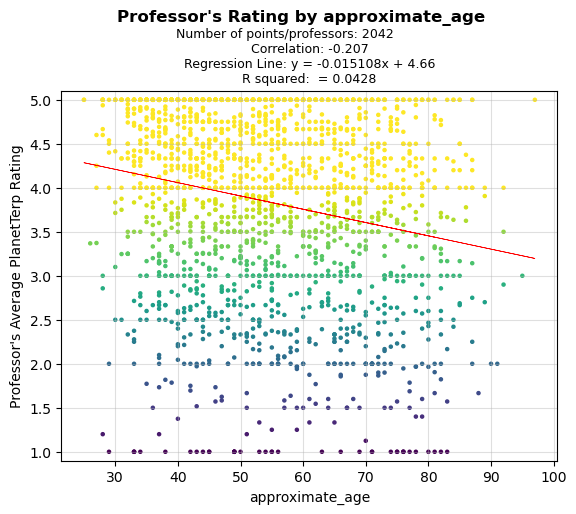
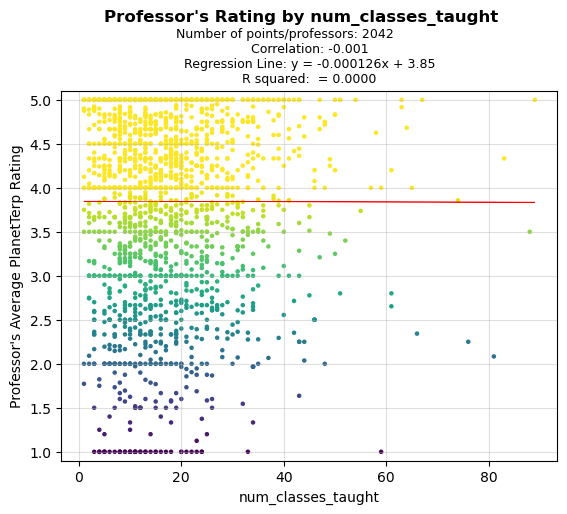

### Analysis of Continuous Variables' Effect on Rating
One consistent phonomenon re-addressed from Checkpoint 2 is the points' adherence towards the integer values of rating. This is because these points probably have only one review, and PlanetTerp only allows integer values of stars as ratings. We deliberately did not drop these low-review professors since the data stll remains relevant.

Observing that the feature of students' GPA has the highest values of correlation of 0.237, regression line slope of 0.54, and R-squared (i.e. the percent of variation in the dependent variable that is explained by the independent variable) of 0.056, it can be concluded that this seems to be the most significant factor before our deeper machine learning analyses. It seems student performance is the highest indicator of professor's rating.

It is worth mentioning that the feature of age has a correlation of -0.207, suggesting that students rate older professors somewhat lower. Maybe the students may have a sort of ageist cynicism towards older professors, and/or maybe the professors may be out of touch with the shifting needs and expectations of the youth.

For the other features of salary, number of reviews, and number of classes taught, the correlation coeffcients, regression line slopes, and R-squared values are too low to be considered as significantly deciding factors in rating, either postively or negatively.

### Plots for Professor Rating by Categorical Data
(department/school, education level, gender)

In [ ]:
independent_variables = ['department','highest_education','gender']

# plot as a bar chart the relationship of individual categorical variables and the professor's rating
def rating_by_categorical_data(independent_variable):
    dep = merged_with_salaries.loc[:,['rating',independent_variable]].groupby(independent_variable).mean()
    dep = dep.sort_values(by='rating',ascending=False)
    dep.plot(kind='bar' ,color='skyblue' )
    plt.grid(True, alpha = 0.4,axis='y')
    plt.title('Average PlanetTerp Rating of Professors by '+independent_variable)
    plt.xticks(rotation=50)
    plt.show()

for independent_variable in independent_variables:
    rating_by_categorical_data(independent_variable)

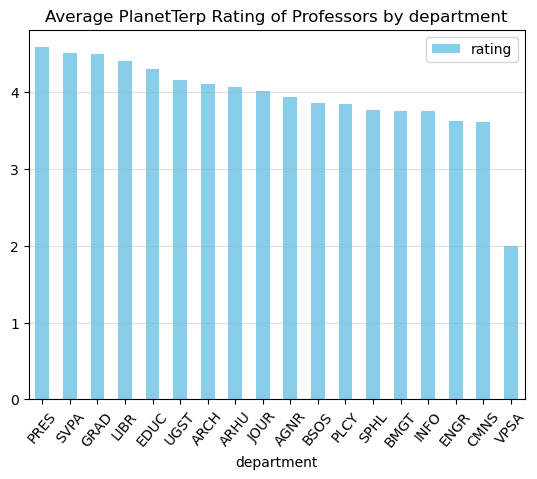

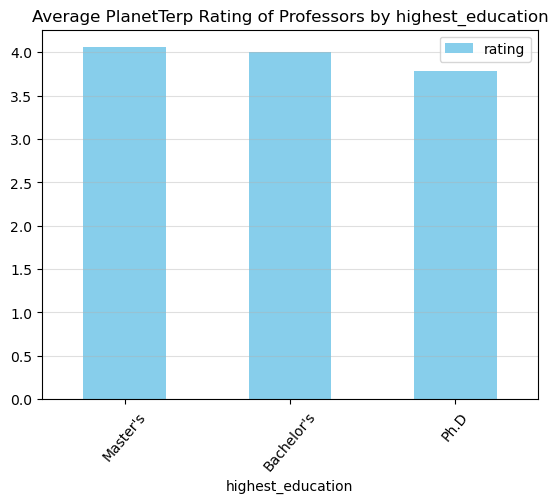

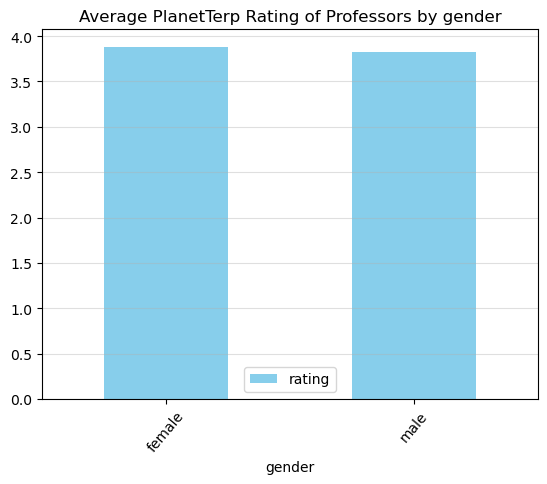

### Analysis of Catagorical Variables' Effect on Rating

Regarding the first graph of rating by UMD department/school, it can be observed that the schools of CMNS (College of Computer, Mathematical, and Natural Sciences), ENGR (James A Clark School of Engineering), and INFO (College of Information) are all related to STEM, moreso relative to the other colleges regarding humanities and social sciences, and these three rank the lowest in professor rating (disregarding VSPA, Vice President for Strategic Planning and Advancement, just 3 people). Perhaps STEM subjects are harder to teach and can lead to more frustrated students.

The graphs for education and gender's affect on rating show no significant relationship, for better or worse; rating seems identical regardless of these factors, although one would initially think higher professor education means higher ratings.

The graph for rating by position (e.g. lecturer, professor emeritus) had too many indistinct and vague roles to distinguish the many groups and their differences to explain their affect on rating, so it was not included.




---

### Additional Data Preprocessing for Primary Machine Learning Analysis
Regarding the machine learning experiment design's binary classification, we found that approximately 56% of professors had an average rating of 4.0 or higher. Student GPA ranged mostly between 2.9 and 3.9. Professors with more reviews or higher GPAs tended to have higher ratings. Some features, like department and position, were unevenly distributed, which we accounted for in preprocessing. Visualizations such as bar plots and summary stats helped us better understand which variables might influence ratings.

In [ ]:
# Creating the binary classification preferable column

df['preferable'] = (df['rating'] >= 4.0).astype(int) # target vector

# Define target
y = df['preferable']

# Define features (excluding target + leakage)
X = df.drop(columns=['preferable', 'Name', 'Unnamed: 0', 'rating'])

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Scale numeric features (good for using Logistic Regression or KNN) (mean = 0, standard deviation = 1)
from sklearn.preprocessing import StandardScaler
num_cols = ['students_gpa', 'approximate_age', 'num_reviews', 'num_classes_taught', 'salary_2024']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [ ]:
print(df['preferable'].value_counts(normalize=True))

preferable
1    0.556317
0    0.443683
Name: proportion, dtype: float64




---


## **Primary Machine Learning Analysis**

Since our goal is to predict whether a professor is *preferable* (i.e., has a rating of 4.0 or higher), we framed this as a **binary classification** problem. After exploring the data, we found that a professor's rating appeared to be influenced by numeric features such as student GPA, number of reviews, and salary, along with categorical features like department and gender.

We selected three classification algorithms to test:

- **Decision Tree (Tuned)**, which splits on features to make interpretable rules and can handle both categorical and numeric data
- **Logistic Regression**, a linear model useful for interpretability and baseline performance
- **K-Nearest Neighbors (KNN)**, a non-parametric model that makes predictions based on similarity


We chose these models because they represent different styles of learning and are straightforward to implement. We used accuracy, precision, recall, and F1 score as our main evaluation metrics. Ultimately, we selected the **tuned decision tree** as our final model because it balanced good performance (F1 ≈ 0.68) with strong interpretability. The tuned decision tree used entropy as its splitting criterion and was limited to a max depth of 5. The tree allowed us to understand which combinations of features led to a “preferable” classification and aligned well with our goal of helping students make informed decisions.


### Model Comparison Summary:
| Model                   | Accuracy | Precision | Recall | F1 Score |
|------------------------|----------|-----------|--------|----------|
| Decision Tree (Tuned)  | 0.66     | 0.72      | 0.64   | 0.68     |
| Logistic Regression    | 0.64     | 0.65      | 0.74   | 0.69     |
| K-Nearest Neighbors    | 0.61     | 0.64      | 0.68   | 0.66     |

In [ ]:
# Untuned Decision Tree Model

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y)

# Create and train the model
tree = DecisionTreeClassifier(random_state=7)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5819070904645477
Precision: 0.6325581395348837
Recall: 0.5964912280701754
F1 Score: 0.6139954853273137
Confusion Matrix:
 [[102  79]
 [ 92 136]]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Tuning The Tree
tuned_tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='entropy',
    random_state=7
)
tuned_tree.fit(X_train, y_train)


# Predict and evaluate
y_pred_tuned = tuned_tree.predict(X_test)

print("Tuned Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned Precision:", precision_score(y_test, y_pred_tuned))
print("Tuned Recall:", recall_score(y_test, y_pred_tuned))
print("Tuned F1 Score:", f1_score(y_test, y_pred_tuned))


Tuned Accuracy: 0.6503667481662592
Tuned Precision: 0.7053140096618358
Tuned Recall: 0.6403508771929824
Tuned F1 Score: 0.671264367816092


In [ ]:
# Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create and train logistic regression model
log_reg = LogisticRegression(random_state=7, max_iter=1000)  # max_iter avoids convergence warnings
log_reg.fit(X_train, y_train)

# Predict
y_pred_log = log_reg.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Precision:", precision_score(y_test, y_pred_log))
print("Logistic Regression Recall:", recall_score(y_test, y_pred_log))
print("Logistic Regression F1 Score:", f1_score(y_test, y_pred_log))


Logistic Regression Accuracy: 0.6356968215158925
Logistic Regression Precision: 0.6525096525096525
Logistic Regression Recall: 0.7412280701754386
Logistic Regression F1 Score: 0.6940451745379876


In [ ]:
# KNN Model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create the model (start with k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)

# Evaluate
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Precision:", precision_score(y_test, y_pred_knn))
print("KNN Recall:", recall_score(y_test, y_pred_knn))
print("KNN F1 Score:", f1_score(y_test, y_pred_knn))


KNN Accuracy: 0.60880195599022
KNN Precision: 0.639344262295082
KNN Recall: 0.6842105263157895
KNN F1 Score: 0.6610169491525424


## **Visualization of Machine Learning Analysis**

We used several visualizations to explain the results of our primary analysis:

- **Confusion Matrix**: We plotted confusion matrices for each machine learning model. The confusion matrix for the tuned decision tree shows how well the model predicted the two classes: “preferable” and “not preferable.” The matrix is labeled with true vs. predicted values, and we can see the balance between true positives and false positives. It had high true positives, 146 (A professor who is predicted to be preferable is actually preferable), and high true negatives (A professor who is predicted to be not preferable is not actually preferable). It helps us understand how the model performs in real classification settings, especially how many professors were correctly or incorrectly labeled as preferable.

- **Decision Tree Diagram**: This visualization shows how the model makes decisions. Each node in the tree represents a feature split based on entropy. For example, a top split may be based on student GPA, followed by number of reviews or salary. The tree is color-coded by class, and each leaf node shows the predicted class, value distribution, and number of samples. This makes the model highly interpretable and useful for understanding which features matter most.

- **Feature Importance Plot**: This bar chart shows the top features used by the decision tree, ranked by how much they contributed to splitting the data. Features like `students_gpa`, `num_reviews`, and `salary_2024` had the highest influence, which aligns with our intuition and earlier exploration.

Each plot includes axis labels, titles, and clear legends where applicable. Together, these visuals demonstrate how the model works and what patterns it found in the data.


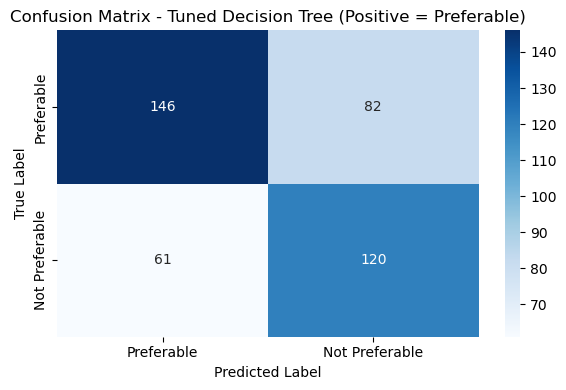

In [ ]:
# Decision Tree for Tuned Decision Tree
cm = confusion_matrix(y_test, y_pred_tuned, labels=[1, 0])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Preferable', 'Not Preferable'],
            yticklabels=['Preferable', 'Not Preferable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Tuned Decision Tree (Positive = Preferable)')
plt.tight_layout()
plt.show()



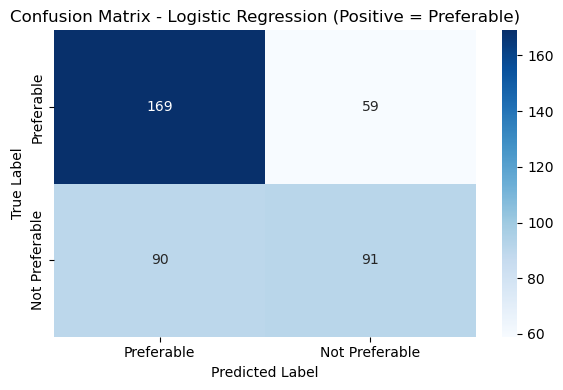

In [ ]:
# Confusion matrix for Logistic Regression with positive class = Preferable
cm_log = confusion_matrix(y_test, y_pred_log, labels=[1, 0])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Preferable', 'Not Preferable'],
            yticklabels=['Preferable', 'Not Preferable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression (Positive = Preferable)')
plt.tight_layout()
plt.show()

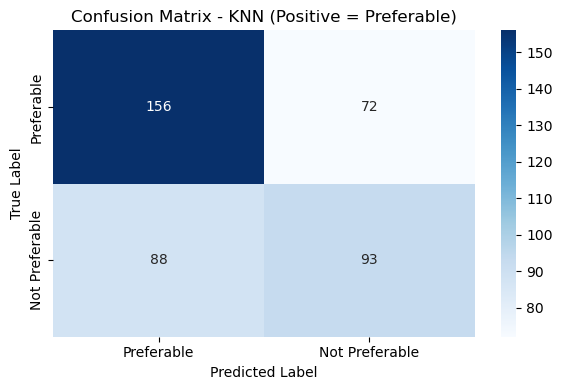

In [ ]:
# Confusion matrix for KNN with positive class = Preferable
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[1, 0])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Preferable', 'Not Preferable'],
            yticklabels=['Preferable', 'Not Preferable'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN (Positive = Preferable)')
plt.tight_layout()
plt.show()

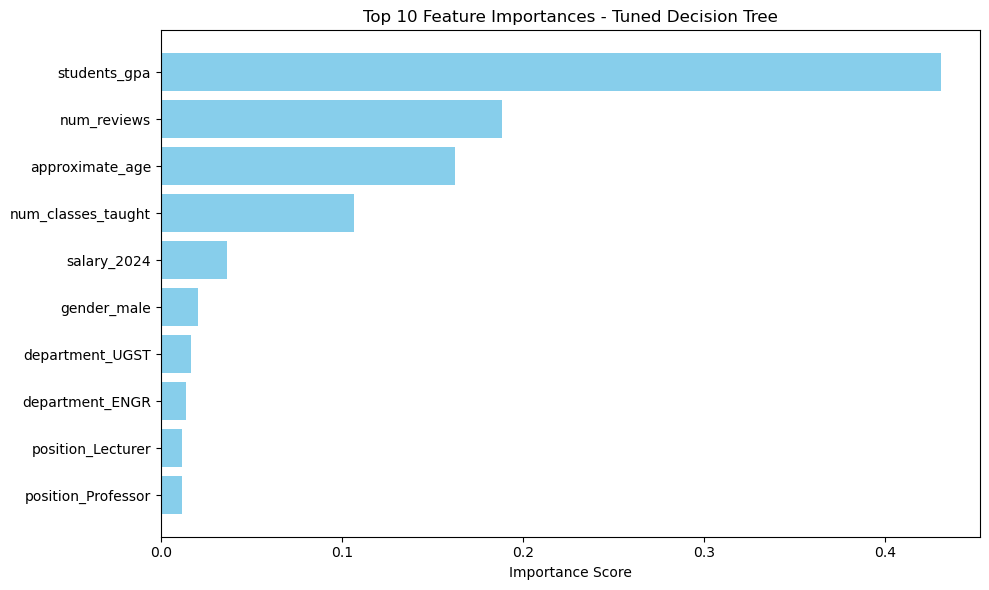

In [ ]:
# Bar Chart of Feature Importance

import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the tree
importances = tuned_tree.feature_importances_ # importances are calculated from the sum of weighted impurity decreases (e.g., Gini or entropy) for each feature, across all splits in the tree, normalized to sum to 1.0
features = X.columns

# Create a DataFrame and sort
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances - Tuned Decision Tree')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


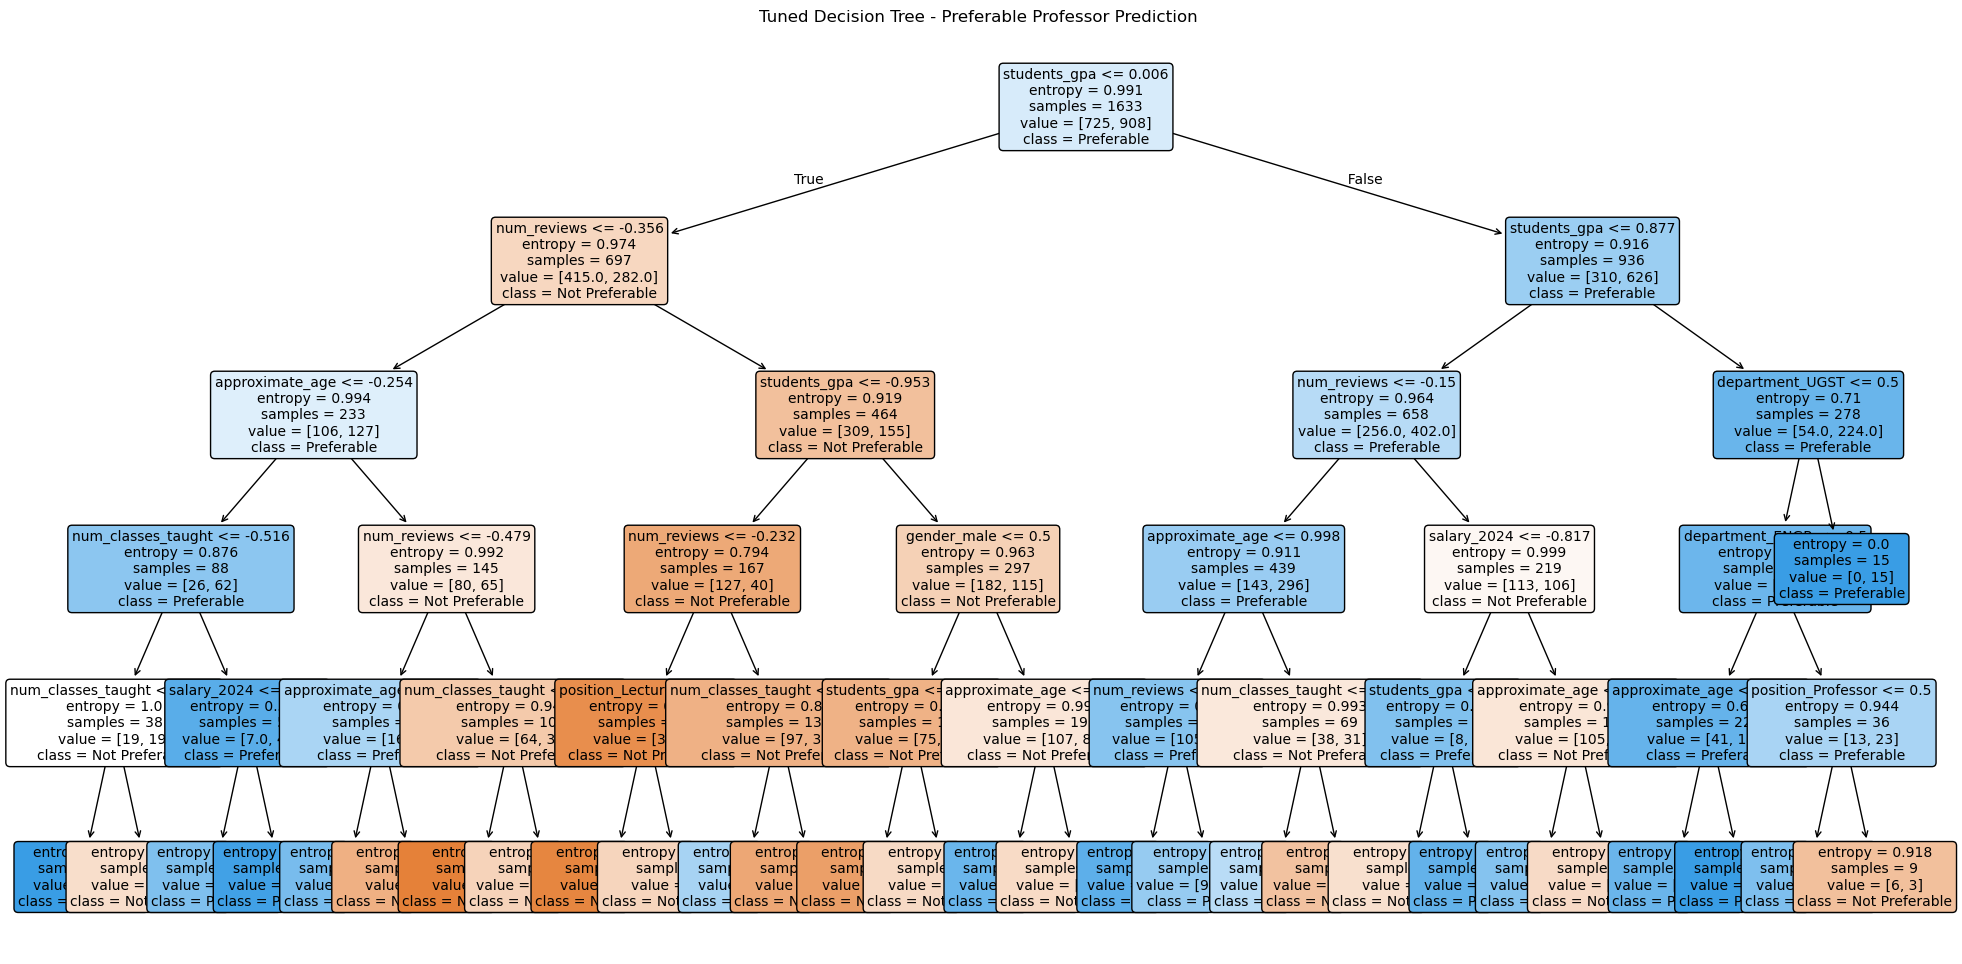

In [ ]:
# Visualizing the Tuned Decision Tree (we will choose the tuned decision tree as our model)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12))  # Adjust size as needed
plot_tree(
    tuned_tree,
    feature_names=X.columns,
    class_names=['Not Preferable', 'Preferable'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Tuned Decision Tree - Preferable Professor Prediction')
plt.show()


## **Insights and Conclusions of the Machine Learning Analysis**

Our project showed that it's possible to predict whether a UMD professor is likely to receive a high rating (4.0 or above) using features such as student GPA, number of reviews, salary, department, and academic position.

After training three classification models, Logistic Regression, K-Nearest Neighbors, and a tuned Decision Tree, we selected the decision tree as our final model due to its interpretability and competitive performance. It achieved an accuracy of around 66% and an F1 score of ~0.68. Although Logistic Regression had a slightly higher F1 score, the tuned Decision Tree achieved the best accuracy (66%) and precision (72%), meaning it was more reliable in identifying preferable professors without incorrectly labeling poor ones. Its confusion matrix showed a more balanced split between true positives and true negatives. We ultimately selected this model not just for performance, but also for interpretability as the tree structure made it easy to understand which features mattered most and how decisions were made.

From the feature importance plot and tree structure, we learned that **students_gpa**, **num_reviews**, and **salary_2024** were the strongest predictors of a professor's rating. These features reflect both the student experience and institutional investment, which makes sense because professors with stronger student performance and more feedback tend to be rated more favorably.

### For an uninformed reader:
This tutorial provides a full walkthrough of how to gather, clean, explore, and model real-world data. It also explains how machine learning can help students make more informed academic choices based on public university data.

### For a more informed reader:
The comparison of multiple classification techniques, use of entropy in the decision tree, and the interpretation of decision boundaries offer deeper insights into model performance and evaluation tradeoffs. The project also raises ideas for future exploration, such as using ensemble methods or tracking professor ratings over time.

